<a href="https://colab.research.google.com/github/intimanjunath/Neural-network-using-numpy-keras-pytorch-and-jax/blob/main/2_PyTorch_3layer_neural_network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

* Generate Synthetic Data & 4D Visualization

In this cell we define a non‑linear function of three variables, generate 1000 samples, and visualize the data in a 3D scatter plot where color represents the target value.

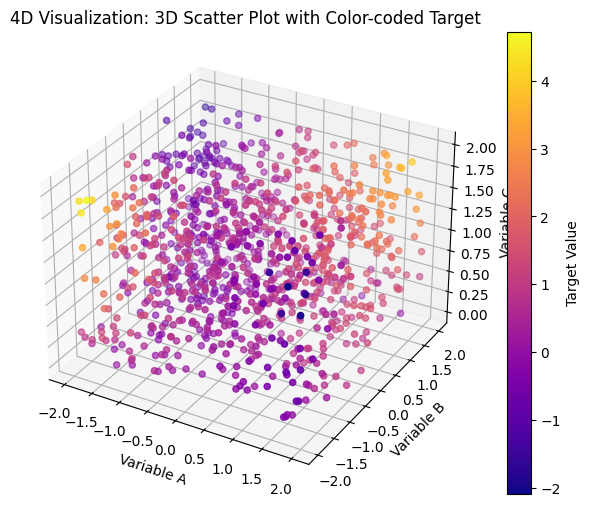

In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D  # Required for 3D plots

# Define a non-linear function with three variables
def nonlinear_func(a, b, c):
    # Example: sin(a)*cos(b) + log(c + 1) + 0.5*a*b*c
    return torch.sin(a) * torch.cos(b) + torch.log(c + 1) + 0.5 * a * b * c

# Set seed for reproducibility
torch.manual_seed(42)
num_samples = 1000

# Generate synthetic data using uniform distribution
a_vals = torch.empty(num_samples, 1).uniform_(-2, 2)   # Variable A in [-2, 2]
b_vals = torch.empty(num_samples, 1).uniform_(-2, 2)   # Variable B in [-2, 2]
c_vals = torch.empty(num_samples, 1).uniform_(0, 2)    # Variable C in [0, 2] (non-negative for log)

# Compute target values using the non-linear function
target_vals = nonlinear_func(a_vals, b_vals, c_vals)

# Convert tensors to NumPy arrays for visualization
a_np = a_vals.numpy()
b_np = b_vals.numpy()
c_np = c_vals.numpy()
target_np = target_vals.numpy()

# Plot the data: 3D scatter plot with color representing the target value
fig = plt.figure(figsize=(8, 6))
ax = fig.add_subplot(111, projection='3d')
sc = ax.scatter(a_np, b_np, c_np, c=target_np, cmap='plasma')
ax.set_xlabel("Variable A")
ax.set_ylabel("Variable B")
ax.set_zlabel("Variable C")
plt.colorbar(sc, label="Target Value")
plt.title("4D Visualization: 3D Scatter Plot with Color-coded Target")
plt.show()

In [2]:
#Data Preprocessing: Normalization & Train/Test Split
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

# Stack inputs (a_vals, b_vals, c_vals) into one array (num_samples x 3)
features = torch.cat((a_vals, b_vals, c_vals), dim=1).numpy()
target_np = target_vals.numpy()

# Normalize features and target using MinMaxScaler
scaler_features = MinMaxScaler()
scaler_target = MinMaxScaler()

features_scaled = scaler_features.fit_transform(features)
target_scaled = scaler_target.fit_transform(target_np)

# Convert the scaled data back to PyTorch tensors
features_scaled = torch.tensor(features_scaled, dtype=torch.float32)
target_scaled = torch.tensor(target_scaled, dtype=torch.float32)

# Split the data into training (80%) and testing (20%) sets
X_train, X_test, y_train, y_test = train_test_split(features_scaled, target_scaled, test_size=0.2, random_state=42)

print("Training data shape:", X_train.shape, y_train.shape)
print("Testing data shape:", X_test.shape, y_test.shape)

Training data shape: torch.Size([800, 3]) torch.Size([800, 1])
Testing data shape: torch.Size([200, 3]) torch.Size([200, 1])


In [3]:
#Initialize the Neural Network Parameters
input_dim = 3       # Three input features (A, B, C)
hidden_dim1 = 10    # Neurons in first hidden layer
hidden_dim2 = 8     # Neurons in second hidden layer
output_dim = 1      # Single output for regression

# For reproducibility
torch.manual_seed(42)

# Initialize weights with small random values and biases as zeros
w1 = torch.randn(input_dim, hidden_dim1) * 0.1   # Shape: (3, 10)
b1 = torch.zeros(1, hidden_dim1)                 # Shape: (1, 10)

w2 = torch.randn(hidden_dim1, hidden_dim2) * 0.1   # Shape: (10, 8)
b2 = torch.zeros(1, hidden_dim2)                 # Shape: (1, 8)

w3 = torch.randn(hidden_dim2, output_dim) * 0.1    # Shape: (8, 1)
b3 = torch.zeros(1, output_dim)                  # Shape: (1, 1)

print("w1 shape:", w1.shape, "b1 shape:", b1.shape)
print("w2 shape:", w2.shape, "b2 shape:", b2.shape)
print("w3 shape:", w3.shape, "b3 shape:", b3.shape)

w1 shape: torch.Size([3, 10]) b1 shape: torch.Size([1, 10])
w2 shape: torch.Size([10, 8]) b2 shape: torch.Size([1, 8])
w3 shape: torch.Size([8, 1]) b3 shape: torch.Size([1, 1])


In [4]:
#Forward Propagation Using torch.einsum
# Define ReLU activation function
def relu_activation(x):
    return torch.maximum(x, torch.tensor(0.0))

# Forward propagation function using torch.einsum
def forward_pass(X):
    # Layer 1: Linear transformation then ReLU activation
    Z1 = torch.einsum('ij,jk->ik', X, w1) + b1  # (batch_size x hidden_dim1)
    A1 = relu_activation(Z1)

    # Layer 2: Linear transformation then ReLU activation
    Z2 = torch.einsum('ij,jk->ik', A1, w2) + b2  # (batch_size x hidden_dim2)
    A2 = relu_activation(Z2)

    # Output layer: Linear transformation (no activation for regression)
    Z3 = torch.einsum('ij,jk->ik', A2, w3) + b3  # (batch_size x output_dim)
    return Z3, (Z1, A1, Z2, A2, Z3)

# Test the forward pass on the training data
y_train_pred, cache = forward_pass(X_train)
print("Sample training predictions:", y_train_pred[:5].flatten())

Sample training predictions: tensor([-0.0063, -0.0040, -0.0036, -0.0044, -0.0086])


* Backpropagation and Training Loop

This cell implements manual backpropagation using the chain rule. We calculate gradients using torch.einsum and update the weights with gradient descent. The Mean Squared Error (MSE) is used as the loss function.

In [5]:
# Define Mean Squared Error (MSE) loss function
def mse_loss(y_true, y_pred):
    return torch.mean((y_true - y_pred) ** 2)

# Define derivative of ReLU activation
def relu_derivative(x):
    return (x > 0).float()

# Training hyperparameters
learning_rate = 0.01
num_epochs = 1000

loss_history = []

for epoch in range(num_epochs):
    # Forward pass
    y_pred, (Z1, A1, Z2, A2, Z3) = forward_pass(X_train)

    # Compute loss
    loss = mse_loss(y_train, y_pred)
    loss_history.append(loss.item())

    # --- Backpropagation ---
    # Output layer gradient (for MSE, derivative = 2*(prediction - target)/N)
    dZ3 = 2 * (y_pred - y_train) / y_train.shape[0]
    dW3 = torch.einsum('ij,ik->jk', A2, dZ3)
    db3 = torch.mean(dZ3, dim=0, keepdim=True)

    # Backpropagation into second hidden layer
    dA2 = torch.einsum('ik,jk->ij', dZ3, w3.T)
    dZ2 = dA2 * relu_derivative(Z2)
    dW2 = torch.einsum('ij,ik->jk', A1, dZ2)
    db2 = torch.mean(dZ2, dim=0, keepdim=True)

    # Backpropagation into first hidden layer
    dA1 = torch.einsum('ij,jk->ik', dZ2, w2.T)
    dZ1 = dA1 * relu_derivative(Z1)
    dW1 = torch.einsum('ij,ik->jk', X_train, dZ1)
    db1 = torch.mean(dZ1, dim=0, keepdim=True)

    # --- Parameter Updates ---
    w3 -= learning_rate * dW3
    b3 -= learning_rate * db3
    w2 -= learning_rate * dW2
    b2 -= learning_rate * db2
    w1 -= learning_rate * dW1
    b1 -= learning_rate * db1

    # Print loss every 100 epochs
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.5f}")

print(f"Final Training Loss: {loss_history[-1]:.5f}")

Epoch 0, Loss: 0.18147
Epoch 100, Loss: 0.16903
Epoch 200, Loss: 0.10322
Epoch 300, Loss: 0.02111
Epoch 400, Loss: 0.02069
Epoch 500, Loss: 0.02046
Epoch 600, Loss: 0.02030
Epoch 700, Loss: 0.02019
Epoch 800, Loss: 0.02011
Epoch 900, Loss: 0.02005
Final Training Loss: 0.02000


In [6]:
# Evaluate the model on test data
y_test_pred, _ = forward_pass(X_test)
test_loss = mse_loss(y_test, y_test_pred)
print(f"Test Loss: {test_loss.item():.5f}")

# Convert PyTorch tensors to NumPy arrays for inverse transformation
y_test_np = y_test.numpy()
y_test_pred_np = y_test_pred.detach().numpy()

# Inverse transform to original scale using scaler_target
y_test_orig = scaler_target.inverse_transform(y_test_np)
y_test_pred_orig = scaler_target.inverse_transform(y_test_pred_np)

# Print first 5 test predictions versus actual values
print("\nFirst 5 Test Predictions vs. Actual:")
for i in range(5):
    print(f"Predicted: {y_test_pred_orig[i][0]:.4f}, Actual: {y_test_orig[i][0]:.4f}")

Test Loss: 0.02187

First 5 Test Predictions vs. Actual:
Predicted: 0.5366, Actual: 1.1071
Predicted: 0.3417, Actual: 1.2131
Predicted: 1.5582, Actual: 1.9714
Predicted: -0.9317, Actual: -0.6978
Predicted: 0.5070, Actual: -0.0541


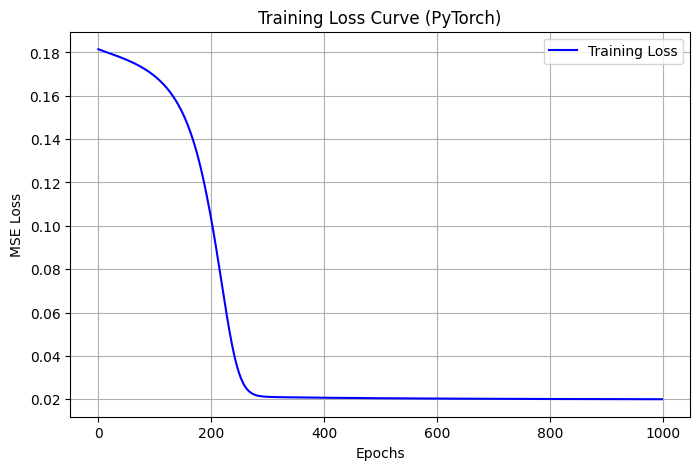

In [7]:
#Visualize the Training Loss Curve

import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(range(num_epochs), loss_history, label="Training Loss", color='blue')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Training Loss Curve (PyTorch)")
plt.legend()
plt.grid(True)
plt.show()